### Alternative approach using SVM, RF and LDA

In [1]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
start = time.time()
npzfile = np.load('HCS_48x48.npz')
print ("Loaded data in " + str(time.time() - start))
npzfile.files
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

Loaded data in 0.000697135925293
Loaded data in 4.53719711304


((52950,), (52950,), (52950, 5, 48, 48), numpy.ndarray)

### Loading the features of the cells

In [3]:
cells_all = pd.read_csv('/home/dueo/data/Genedata/Cells.csv')
cells = cells_all.iloc[cell_rows]
np.shape(cells)

(52950, 407)

In [4]:
cells.ix[0:2,'AreaShape_Area':]
#cells.ix[0:2]

,AreaShape_Area,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_Compactness,AreaShape_Eccentricity,AreaShape_EulerNumber,AreaShape_Extent,AreaShape_FormFactor,AreaShape_MajorAxisLength,AreaShape_MaxFeretDiameter,...,Texture_Variance_ER_3_0,Texture_Variance_ER_5_0,Texture_Variance_Golgi_Actin_3_0,Texture_Variance_Golgi_Actin_5_0,Texture_Variance_Hoechst_3_0,Texture_Variance_Hoechst_5_0,Texture_Variance_Mito_3_0,Texture_Variance_Mito_5_0,Texture_Variance_Nucleoli_3_0,Texture_Variance_Nucleoli_5_0
0,5520,542,43,1.297952,0.837477,1,0.484295,0.141449,118.346136,142.618372,...,0.963408,0.942669,1.432731,1.470543,2.608476,2.653153,1.357492,1.328036,1.516640,1.495042
1,6126,317,52,1.230381,0.769741,1,0.609977,0.375944,116.594822,130.782262,...,1.070573,1.084703,1.917686,1.915602,2.261544,2.322472,1.621720,1.628327,1.489087,1.491358
2,11618,438,82,1.091077,0.522378,1,0.625431,0.284604,136.470704,152.463110,...,0.703105,0.714262,1.621151,1.623899,1.664106,1.705266,1.610848,1.621337,1.679954,1.700747


### Extracting the features and imputing NaNs

In [5]:
X_features = np.asmatrix(cells.ix[:,'AreaShape_Area':])
np.shape(X_features)

(52950, 396)

In [6]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_features)
X_features = imp.transform(X_features)

### Normalization

In [7]:
Xmean = X_features.mean(axis = 0)
XStd = np.sqrt(X_features.var(axis=0))
X = (X_features-Xmean)/(XStd + 0.01)

In [8]:
np.max(X[:,1])

1.8173680921031092

In [9]:
np.min(X), np.max(X), np.mean(X)

(-69.705828219351631, 132.78221451686983, -2.7136455336971616e-18)

In [10]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

## Splitting in training and test-set



#### Version 1
80%, 20% randomly choosen

In [144]:
# Currently a Acc. of 0.8250
if False:
    split = 40000
    X_train = X[0:split,:]
    Y_train = Y[0:split]
    X_test = X[split:,:]
    Y_test = Y[split:]

#### Version 3 (Separation of complete well)
Separating a complete well from the training set and use this for testing

In [112]:
if False:
    idx_test = np.asarray(np.recfromtxt ('test_set_data.csv'))
    np.sum(idx_test)

2854

#### Version 4 (As suggested by the reviewer)
Separation of a complete compound

In [82]:
if False:
    idx_test = np.asarray(np.recfromtxt ('test_set_data_without_one_compound.csv'))
    #idx_test = np.asarray(np.recfromtxt ('test_set_data_without_one_compound_first_no_DMSO.csv'))
    idx_train = idx_test == False
    np.sum(idx_test), idx_test.shape, np.sum(idx_test & idx_train)

(3113, (52950,), 0)

In [83]:
idx_test.shape

(52950,)

In [84]:
X_train = X[idx_test== False]
X_test = X[idx_test]

Y_train = Y[idx_test== False]
Y_test = Y[idx_test]

X_test.shape, Y_test.shape, X_train.shape, Y_train.shape

((3113, 396), (3113,), (49837, 396), (49837,))

In [85]:
Y.max() == 2 

True

#### NO DMSO and  (Separation of complete well)

In [11]:
if True:
    if Y.max() == 3:
        Y = Y -1
    idx_DMSO = np.asarray(np.recfromtxt ('DMSO_data.csv'))
    print('Number of DMSO {}'.format(np.sum(idx_DMSO)))

    #idx_test_all = np.asarray(np.recfromtxt ('test_set_data.csv'))
    #idx_test_all = np.asarray(np.recfromtxt ('test_set_data_without_one_compound_second_no_DMSO.csv'))
    idx_test_all = np.asarray(np.recfromtxt ('test_set_data_without_one_compound.csv'))
    
    idx_train = (idx_test_all == False) & (idx_DMSO == False)
    idx_test  = idx_test_all & (idx_DMSO == False)

    X_train = X[idx_train]
    Y_train = Y[idx_train]

    X_test = X[idx_test]
    Y_test = Y[idx_test]

    print('Finished Number of Training Data {} Number of test data {}'.format(np.sum(idx_train), np.sum(idx_test)))
    X_test.shape, Y_test.shape, X_train.shape, Y_train.shape #1964 and 10203

Number of DMSO 40783
Finished Number of Training Data 9944 Number of test data 2223


In [130]:
# Currently a Acc. of 0.8976
if False:
    np.random.seed(seed=42)
    perm1 = np.random.permutation(len(Y))
    print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
    N_split = int(len(Y) * 0.8)
    N_split
    idx_train  = perm1[:N_split]
    idx_test  = perm1[N_split:]


    X_train = X[idx_train,:]
    Y_train = Y[idx_train]
    X_test = X[idx_test,:]
    Y_test = Y[idx_test]

#### Permuting the training set

In [12]:
perm = np.random.permutation(len(Y_train))
X_train_perm = X_train[perm]
Y_train_perm = Y_train[perm]

In [13]:
np.histogram(cells['Metadata_Phenotype'][idx_train],bins=[0, 1, 2, 3, 4])

(array([   0, 1541, 8057,  346]), array([0, 1, 2, 3, 4]))

In [14]:
cells['Metadata_Compound'].unique(),len(cells['Metadata_Compound'].unique())

(array(['PACLITAXEL', 'DMSO', 'FENBENDAZOLE', 'METOCLOPRAMIDE', 'PROCAINE',
        'DIGOXIN', 'FLUPHENAZINE', 'OXIBENDAZOLE', 'NERIIFOLIN',
        'DIGITOXIN', 'PERUVOSIDE'], dtype=object), 11)

In [15]:
cells['Metadata_Compound'][idx_train].unique(),len(cells['Metadata_Compound'][idx_train].unique())

(array(['FENBENDAZOLE', 'METOCLOPRAMIDE', 'DIGOXIN', 'FLUPHENAZINE',
        'OXIBENDAZOLE', 'NERIIFOLIN', 'DIGITOXIN'], dtype=object), 7)

In [16]:
cells['Metadata_Compound'][idx_test].unique()

array(['PACLITAXEL', 'PROCAINE', 'PERUVOSIDE'], dtype=object)

### Fisher-LDA

In [17]:
from sklearn.lda import LDA
clf = LDA()
clf.fit(X_train_perm, Y_train_perm)

/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:161: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LDA(n_components=None, priors=None)

In [18]:
Y_train_perm.shape

(9944,)

In [19]:
Y_pred_lda_in_sample = clf.predict(X_train_perm)
sum(Y_pred_lda_in_sample == (Y_train_perm ))/float(len(Y_train_perm))

0.97827835880933223

In [20]:
Y_pred_lda = clf.predict(X_test)
Y_pred_lda.min(), Y_pred_lda.max(), Y_test.min(), Y_test.max()

(0, 2, 0, 2)

In [21]:
sum(Y_pred_lda == (Y_test ) )/float(len(Y_test))

0.9464687359424202

In [114]:
confusion_matrix(Y_pred_lda, Y_test)

array([[ 437,  105,    3],
       [   9, 1602,    0],
       [   1,    1,   65]])

In [22]:
pred_prob_lda = clf.predict_proba(X_test)

### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=4,n_estimators=500,oob_score=True)
clf.fit(X_train_perm, Y_train_perm)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=500, n_jobs=4,
            oob_score=True, random_state=None, verbose=0)

In [24]:
clf.oob_score_

0.96319388576025744

In [25]:
Y_pred_rf = clf.predict(X_test)

In [26]:
sum(Y_pred_rf == Y_test)/float(len(Y_test))

0.90193432298695453

In [27]:
confusion_matrix(Y_pred_rf, Y_test)

array([[ 363,  132,    1],
       [  78, 1575,    0],
       [   6,    1,   67]])

In [28]:
pred_prob_RF = clf.predict_proba(X_test)

### 10 Fold X-Validation

We use a 10 fold crossvalidation on the training set to find the optimal parameters

### Sampling 

For the SVM we sample so that the classes have equal proportions.

In [29]:
hist = np.histogram(Y_train_perm, bins=[0, 1, 2, 3,4])
NMAX = np.min(hist[0])
hist, NMAX

((array([1541, 8057,  346,    0]), array([0, 1, 2, 3, 4])), 0)

In [30]:
if False:
    idx3 = np.argwhere(Y_train_perm == 3)
    idx2 = np.argwhere(Y_train_perm == 2)
    idx1 = np.argwhere(Y_train_perm == 1)
    idx0 = np.argwhere(Y_train_perm == 0)[0:7877]
    idx_d = np.concatenate((idx0,idx1,idx2,idx3))[:,0] #Orderedness is problem in studip k-fold

    perm_d = np.random.permutation(len(idx_d))
    idx = idx_d[perm_d]
    idx.shape

#### In the case of no DSMO

In [36]:
if True:
    YY = Y_train_perm
    hist = np.histogram(YY, bins=[0, 1, 2, 3,4])
    NMAX = np.min(hist[0])
    NMAX = 352
    hist, NMAX

In [37]:
if True:
    idx2 = np.argwhere(YY == 2)[0:NMAX]
    idx1 = np.argwhere(YY == 1)[0:NMAX]
    idx0 = np.argwhere(YY == 0)[0:NMAX]
    idx_d = np.concatenate((idx0,idx1,idx2))[:,0] #Orderedness is problem in studip k-fold
    perm_d = np.random.permutation(len(idx_d))
    idx = idx_d[perm_d]
    idx.shape

In [38]:
XX1 = X_train_perm[idx]
YY1 = Y_train_perm[idx]
np.shape(XX1), np.shape(YY1),np.shape(X_train_perm),np.shape(idx)

((1050, 396), (1050,), (9944, 396), (1050,))

In [39]:
np.histogram(YY1,  bins=[0, 1, 2, 3,4])

(array([352, 352, 346,   0]), array([0, 1, 2, 3, 4]))

In [40]:
YY1[1:10]

array([1, 1, 0, 1, 1, 0, 2, 1, 2], dtype=int32)

In [41]:
def eval_10_Fold(C = 0.5):
    N = len(XX1)
    kf = KFold(N, n_folds=10)
    acc = 0.0
    rounds = 0.0
    for train, test in kf:
        model = svm.SVC(kernel='linear', C=C).fit(XX1[train,],YY1[train])
        res = model.predict(XX1[test])
        acc += sum(res == YY1[test])/float(len(test)) #Accuracy
        rounds += 1.0
        print('round ={0} C={1} acc (cumulated over the folds) ={2}'.format(rounds, C, acc / rounds))
    return acc

In [42]:
#Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1,1e2,1e3)
Cs = (1e-3,5e-3,1e-2,5e-2,1e-1,1e0,1e+1)
#Cs = np.logspace(np.log10(0.001), 2,20)#Schon Komisch, dass man noch ein log drum muss
res = np.zeros(len(Cs))
for i,C in enumerate(Cs):
    res[i] = eval_10_Fold(C)

round =1.0 C=0.001 acc (cumulated over the folds) =0.857142857143
round =2.0 C=0.001 acc (cumulated over the folds) =0.87619047619
round =3.0 C=0.001 acc (cumulated over the folds) =0.879365079365
round =4.0 C=0.001 acc (cumulated over the folds) =0.890476190476
round =5.0 C=0.001 acc (cumulated over the folds) =0.885714285714
round =6.0 C=0.001 acc (cumulated over the folds) =0.895238095238
round =7.0 C=0.001 acc (cumulated over the folds) =0.899319727891
round =8.0 C=0.001 acc (cumulated over the folds) =0.896428571429
round =9.0 C=0.001 acc (cumulated over the folds) =0.899470899471
round =10.0 C=0.001 acc (cumulated over the folds) =0.902857142857
round =1.0 C=0.005 acc (cumulated over the folds) =0.933333333333
round =2.0 C=0.005 acc (cumulated over the folds) =0.928571428571
round =3.0 C=0.005 acc (cumulated over the folds) =0.930158730159
round =4.0 C=0.005 acc (cumulated over the folds) =0.933333333333
round =5.0 C=0.005 acc (cumulated over the folds) =0.929523809524
round =6.0

((0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 10.0),
 array([ 9.02857143,  9.31428571,  9.38095238,  9.40952381,  9.35238095,
         9.4       ,  9.4       ]))

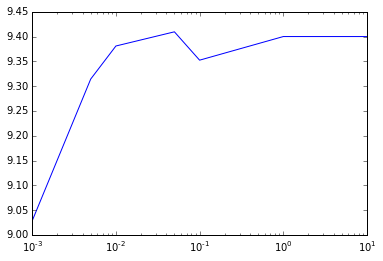

In [43]:
plt.semilogx(Cs,res)
#plt.plot(Cs,res)

(Cs,res)

### Evaluation on the test set

Training the model on the whole training data set

In [55]:
model = svm.SVC(kernel='linear', C=0.1, probability=True).fit(XX1,YY1)
#model = svm.SVC(probability=True, kernel='linear', C=0.01).fit(XX1,YY1)
#model = svm.SVC(probability=True, C=0.01).fit(X_train,Y_train)
#model = svm.SVC(probability=True, C=0.05).fit(XX,YY) #Fit on not sampled

In [56]:
X_train.shape

(9944, 396)

In [57]:
YY1.shape

(1050,)

In [58]:
pred = model.predict(X_test)

In [59]:
model.predict(X_test)
pred_prob_svm = model.predict_proba(X_test)

In [60]:
sum(pred == Y_test)/float(len(Y_test))

0.87539361223571754

In [38]:
pred_prob_RF

array([[ 0.974,  0.   ,  0.026,  0.   ],
       [ 0.862,  0.004,  0.132,  0.002],
       [ 0.966,  0.   ,  0.034,  0.   ],
       ..., 
       [ 0.96 ,  0.   ,  0.04 ,  0.   ],
       [ 0.862,  0.002,  0.132,  0.004],
       [ 0.976,  0.   ,  0.024,  0.   ]])

In [55]:
%load_ext rpy2.ipython
%Rpush pred_prob_RF
%Rpush pred_prob_lda
%Rpush pred_prob_svm
%Rpush Y_test

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R
save(pred_prob_RF, pred_prob_lda, pred_prob_svm, Y_test, file='Test_Like_SIBS_lda_rf_svm.Rdata')

### Calucation of the confusion matrix

In [ ]:
m = confusion_matrix(pred, Y_test)
m

In [ ]:
m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))

In [ ]:
names_col = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names_col
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

In [ ]:
#cm_normalized = m.astype('float') / ((m.sum(axis=1)[:, np.newaxis]))
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))
print('Normalized confusion matrix')


df = pd.DataFrame(cm_normalized)
df.columns = names_col
df.index = names
df

In [ ]:
np.mean(cm_normalized[np.diag_indices(4)])

In [ ]:
1-np.mean(cm_normalized[np.diag_indices(4)])